<a href="https://colab.research.google.com/github/Umang-ai/FraudDetection/blob/main/FraudDetectXgB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install XGBoost
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivamsaurav17","key":"1ce29e11460f38b93dea40af20d2566c"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                                  14473  2025-03-19 03:51:40.270000          11979        211  1.0              
adilshamim8/student-depression-dataset                            Student Depression Dataset                              467020  2025-03-13 03:12:30.423000           4275         68  1.0              
abdulmalik1518/mobiles-dataset-2025                               Mobiles Dataset (2025)                                   20314  2025-02-18 06:50:24.370000          17580        294  1.0     

In [ ]:
!kaggle datasets download -d ealaxi/paysim1


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0


In [ ]:
!mkdir train

In [ ]:
!unzip paysim1.zip -d dataset/


Archive:  paysim1.zip
  inflating: dataset/PS_20174392719_1491204439457_log.csv  


In [ ]:

# Replace 'your_file.csv' with the actual filename
df = pd.read_csv("dataset/PS_20174392719_1491204439457_log.csv")

# Display first few rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
train_df = df  # Skip problematic rows
print(train_df.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [ ]:

df = df.drop(columns=['nameOrig', 'nameDest'])

# Check for missing values
df.dropna(inplace=True)





In [ ]:

# Encode categorical feature
label_enc = LabelEncoder()
df['type'] = label_enc.fit_transform(df['type'])

# Define features and target variable
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [ ]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Initialize Stratified K-Fold (3 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Store metrics for averaging later
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

for train_idx, test_idx in kf.split(X, y):
    print(f"\nTraining on Fold {fold}...")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply SMOTE only to training data
    smote = SMOTE(sampling_strategy=0.2, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    xgb_model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_pred = xgb_model.predict(X_test)
    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # ROC-AUC Score
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred)
        roc_auc_scores.append(roc_auc)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fold += 1



Training on Fold 1...
Accuracy: 0.9967
Precision: 0.2797
Recall: 0.9963
F1 Score: 0.4367
Confusion Matrix:
[[1266668    4214]
 [      6    1636]]

Training on Fold 2...
Accuracy: 0.9969
Precision: 0.2955
Recall: 0.9915
F1 Score: 0.4553
Confusion Matrix:
[[1267001    3881]
 [     14    1628]]

Training on Fold 3...
Accuracy: 0.9967
Precision: 0.2797
Recall: 0.9951
F1 Score: 0.4367
Confusion Matrix:
[[1266671    4210]
 [      8    1635]]

Training on Fold 4...
Accuracy: 0.9969
Precision: 0.2918
Recall: 0.9909
F1 Score: 0.4508
Confusion Matrix:
[[1266930    3951]
 [     15    1628]]

Training on Fold 5...
Accuracy: 0.9969
Precision: 0.2924
Recall: 0.9909
F1 Score: 0.4516
Confusion Matrix:
[[1266942    3939]
 [     15    1628]]


In [ ]:
# Final Performance Metrics
print("\nFinal Model Evaluation (Averaged over 5 folds):")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average ROC-AUC Score: {np.mean(roc_auc_scores):.4f}")


Final Model Evaluation (Averaged over 5 folds):
Average Accuracy: 0.9968
Average Precision: 0.2878
Average Recall: 0.9929
Average F1 Score: 0.4462
Average ROC-AUC Score: 0.9949


**Adjusting the Decision Threshold for Better Precision-Recall Trade-off**




Optimal Threshold: 0.9432
Adjusted Accuracy: 0.9997
Adjusted Precision: 0.9215
Adjusted Recall: 0.8716
Adjusted F1 Score: 0.8958
Adjusted Confusion Matrix:
[[1270759     122]
 [    211    1432]]


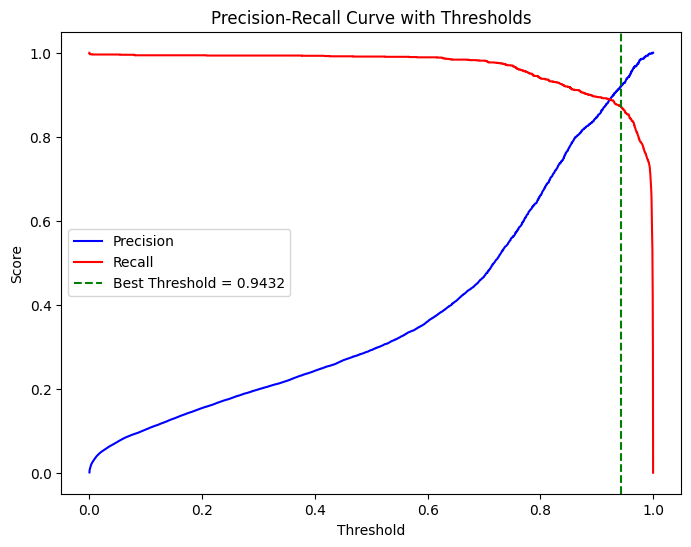

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities instead of binary labels
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Extract fraud probability

# Compute Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1-score for different thresholds
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]  # Find the best threshold

# Convert probabilities to binary predictions using the new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Evaluate the new predictions
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
cm = confusion_matrix(y_test, y_pred_adjusted)

# Print new results
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Adjusted Accuracy: {accuracy:.4f}")
print(f"Adjusted Precision: {precision:.4f}")
print(f"Adjusted Recall: {recall:.4f}")
print(f"Adjusted F1 Score: {f1:.4f}")
print(f"Adjusted Confusion Matrix:\n{cm}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.axvline(best_threshold, linestyle="--", color="green", label=f"Best Threshold = {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve with Thresholds")
plt.show()
